- x1-x2, y1-y2 좌표 안나옴. 계산 필요. box -> 4개의 점만 나옴
- angle 기준 달라서 합성 적용시 미디어 파이프를 사용한 각도 이용하는것이 더 정확할 것 같음 
- 참고: https://namkeenman.wordpress.com/2015/12/21/opencv-determine-orientation-of-ellipserotatedrect-in-fitellipse/
- =====================================
- 네일 디자인 분할할 경우, 각 손톱의 박스 위치를 활용 사용에 용이할듯

In [2]:
import cv2, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import glob as gb
import tqdm
import os

In [11]:
def rot_crop_box3(img):   # 이미지 먼저 불러오고 사용하기
  global crop_img, img_box, angle_lst ,angle_lst2, cenetr_lst, side_x_lst, side_y_lst, box_lst

#   img = cv2.imread(img_path)
  
  mult = 1  # 자르는 이미지 비율, 1: 딱 맞게 자르기
  # img_box = cv2.cvtColor(img5.copy(), cv2.COLOR_GRAY2BGR)
  img_box = img.copy()
  
  edge = cv2.dilate(img_box, None)
  blur = cv2.GaussianBlur(edge, ksize = (3, 3), sigmaX = 0)
  edged = cv2.Canny(blur, 200, 255)       # 경계선 따기
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel) 
  contours, _ = cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)     

  crop_img, angle_lst = [], []     # 자른 이미지 담을 리스트 , 변환 전 좌표 
  angle_lst2, cenetr_lst = [], []  # 변환 후 좌표, 각 객체 중심 좌표
  side_x_lst, side_y_lst = [], []  # x1-x2, y1-y2
  box_lst = []
  for i, cnt in enumerate(contours):
      rect = cv2.minAreaRect(cnt)
      box = cv2.boxPoints(rect)
      box = np.int0(box)
      box_lst.append(box)
      cv2.drawContours(img_box, [box], 0, (0,255,0), 2) # 박스 그리기|

      W, H = rect[1][0], rect[1][1]

      Xs = [i[0] for i in box]
      Ys = [i[1] for i in box]
      x1, x2, y1, y2 = min(Xs), max(Xs), min(Ys), max(Ys)

      angle = rect[2]
      angle_lst.append(angle) # 확인용 - 원래 각도 확인 
      
      if angle>0:
            if W < H:                                # 너비가 높이보다 작으면 
                  angle = (angle)                    # 원래 각도만큼 반시계방향 회전
                  print(f' W < H // index num :{i}') # 확인용
            else:                                    # 높이가 너비보다 작으면 
                  angle = -(90-angle)                # 90-angle 만큼 시계방향 회전
      # elif angle <0: # 혹시 몰라서 남겨둠! 불필요하면 제거하기
      #       if W < H:
      #             angle = (-90-angle)
                  
      angle_lst2.append(angle) # 확인용 - 변형 후 각도 확인 
            
      center, size  = (int((x1+x2)/2), int((y1+y2)/2)), (int(mult*(x2-x1)),int(mult*(y2-y1)))
      cv2.circle(img_box, center, 1, (0,255,0), -1) # 가운데 점 그리기'
      cenetr_lst.append(center) # 확인용 - 중심좌표

      M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0) # angle 만큼 반시계방향 회전
      
      cropped = cv2.getRectSubPix(img_box, size, center)    
      cropped = cv2.warpAffine(cropped, M, size)
      
      croppedW = W if W < H else H
      croppedH = H if W < H else W

      croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW * mult), int(croppedH * mult)), (size[0]/2, size[1]/2)) 
      crop_img.append(croppedRotated)

      plt.subplot(1, len(contours), i+1)
      plt.title(f'index: {i}')
      plt.imshow(croppedRotated)
      # plt.show()

#   plt.imshow(img_box)
  plt.show()

In [16]:
# 결과 확인용
def check_result(img):
    # print(box_lst) # 박스 좌표 확인
    rot_crop_box3(img)
    print(f'- 변환 전 각도: {angle_lst} \n- 변환 후 각도: {angle_lst2} \n- 각 이미지 중심 좌표: {cenetr_lst}')
    plt.imshow(img_box)

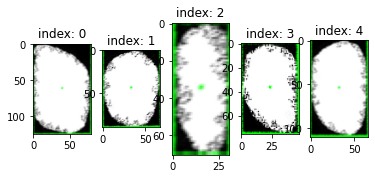

- 변환 전 각도: [24.623563766479492, 29.357755661010742, 39.80557632446289, 31.82744598388672, 32.19573211669922] 
- 변환 후 각도: [-65.37643623352051, -60.64224433898926, -50.19442367553711, -58.17255401611328, -57.80426788330078] 
- 각 이미지 중심 좌표: [(491, 1022), (292, 531), (718, 386), (503, 374), (348, 340)]


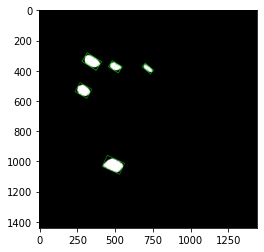

In [18]:
img_1 = cv2.imread('/Users/hyunjinkim/Desktop/final-4조/손_750.jpg')
check_result(img_1)

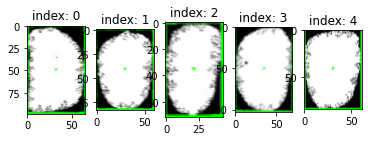

- 변환 전 각도: [43.80651092529297, 47.48955535888672, 45.0, 38.990997314453125, 45.0] 
- 변환 후 각도: [-46.19348907470703, -42.51044464111328, -45.0, -51.009002685546875, -45.0] 
- 각 이미지 중심 좌표: [(528, 855), (379, 413), (735, 334), (377, 283), (530, 266)]


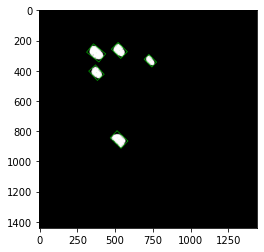

In [19]:
img_1 = cv2.imread('/Users/hyunjinkim/Desktop/final-4조/손_707.jpg')
check_result(img_1)

 W < H // index num :3


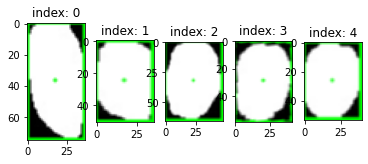

- 변환 전 각도: [90.0, 90.0, 90.0, 5.710592269897461, 90.0] 
- 변환 후 각도: [-0.0, -0.0, -0.0, 5.710592269897461, -0.0] 
- 각 이미지 중심 좌표: [(605, 466), (145, 354), (251, 228), (426, 206), (322, 180)]


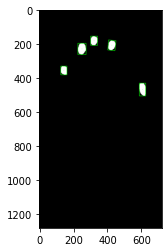

In [20]:
img_1 = cv2.imread('/Users/hyunjinkim/Desktop/final-4조/test/son_mask.jpeg')
check_result(img_1)

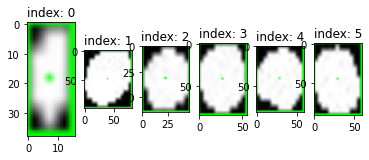

- 변환 전 각도: [90.0, 90.0, 90.0, 90.0, 0.0, 0.0] 
- 변환 후 각도: [-0.0, -0.0, -0.0, -0.0, 0.0, 0.0] 
- 각 이미지 중심 좌표: [(841, 813), (919, 763), (97, 518), (714, 314), (314, 300), (502, 223)]


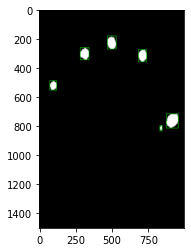

In [22]:
# resize 후 적용해보기
img = cv2.imread('/Users/hyunjinkim/Desktop/final-4조/모델마스크_손_799.jpg')
hand_mask_0 = cv2.resize(img, (1000, 1500))
plt.imshow(hand_mask_0)

check_result(hand_mask_0)

 W < H // index num :0


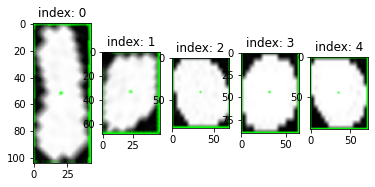

- 변환 전 각도: [47.29060745239258, 56.3099365234375, 90.0, 90.0, 90.0] 
- 변환 후 각도: [47.29060745239258, -33.6900634765625, -0.0, -0.0, -0.0] 
- 각 이미지 중심 좌표: [(844, 831), (30, 603), (184, 468), (517, 451), (307, 404)]


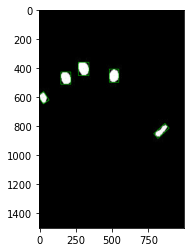

In [23]:
parh = '/Users/hyunjinkim/Desktop/final-4조/모델마스크_손_6.jpg'
img = cv2.imread(parh)
hand_mask_0 = cv2.resize(img, (1000, 1500))
plt.imshow(hand_mask_0)

check_result(hand_mask_0)